<a href="https://colab.research.google.com/github/Purva0210/upskillcampus/blob/main/SmartCityTrafficForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# STEP 1: File Paths
main_zip_path = '/content/Project9_smart-city-traffic-patterns.zip'
extract_dir = '/content/extracted_traffic_data'
os.makedirs(extract_dir, exist_ok=True)

# STEP 2: Extract main ZIP
print("Extracting main ZIP file...")
with zipfile.ZipFile(main_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print("Main ZIP extracted successfully")

# STEP 3: Look for inner ZIPs (if any)
inner_zip = None
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        if file.endswith('.zip'):
            inner_zip = os.path.join(root, file)
            print("Found inner ZIP:", inner_zip)
            break

if inner_zip:
    final_dir = os.path.join(extract_dir, 'final_traffic_data')
    os.makedirs(final_dir, exist_ok=True)
    with zipfile.ZipFile(inner_zip, 'r') as zip_ref:
        zip_ref.extractall(final_dir)
    print("Inner ZIP extracted successfully")
else:
    final_dir = extract_dir

# STEP 4: Find CSV files (modified to search recursively)
csv_files = []
for root, dirs, files in os.walk(final_dir):
    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))

print("\nAvailable CSV files:")
if not csv_files:
    print("No CSV files found in the extracted directory or its subdirectories.")
    raise FileNotFoundError("No CSV files available for selection.")
for i, f in enumerate(csv_files, 1):
    print(f"{i}. {os.path.basename(f)}") # Display just the filename

# User selects CSV file
# Changed to a hardcoded choice to avoid interactive input and select the first CSV.
choice = 0
selected_csv = csv_files[choice]
print(f"\nYou selected: {os.path.basename(selected_csv)}")

# STEP 5: Load CSV
file_path = selected_csv
df = pd.read_csv(file_path)

print("\nDataset Preview:")
display(df.head())

print("\nDataset Columns:")
print(df.columns)

# STEP 6: Preprocessing
df.columns = df.columns.str.strip().str.lower()
df = df.loc[:, ~df.columns.str.contains('unnamed')]

# STEP 7: Feature Engineering
# Check if 'date' column exists, if not, try 'datetime' as per the original problem description
date_col = None
if 'date' in df.columns:
    date_col = 'date'
elif 'datetime' in df.columns:
    date_col = 'datetime'

if date_col and 'junction' in df.columns:
    df[date_col] = pd.to_datetime(df[date_col])
    df['day_of_week'] = df[date_col].dt.dayofweek
    df['month'] = df[date_col].dt.month
    df['year'] = df[date_col].dt.year
else:
    print(f"Warning: 'date' or 'datetime' column not found for time-based feature extraction. Columns found: {df.columns.tolist()}")

# STEP 8: Prepare X and y
# Assuming 'Vehicles' is the target column based on typical traffic datasets.
if 'vehicles' in df.columns:
    y = df['vehicles']
    columns_to_drop = ['vehicles']
    if date_col:
        columns_to_drop.append(date_col)
    X = df.drop(columns=columns_to_drop)

    # One-hot encode categorical features (junctions, holidays, events)
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
else:
    raise ValueError("Dataset must contain 'vehicles' column as target!")

# Fill missing values
X.fillna(0, inplace=True)
y.fillna(y.mean(), inplace=True)

# STEP 9: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# STEP 10: Train model
model = LinearRegression()
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
predictions = model.predict(X_test)

print(f"\nModel Accuracy: {accuracy:.4f}")
print("\nSample Predictions:")
print(np.round(predictions[:10], 0))

# STEP 11: Optional - compare predictions with actual values
comparison = pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted': np.round(predictions[:10], 0)
})
print("\nComparison of Actual vs Predicted Traffic Counts:")
print(comparison)

Extracting main ZIP file...
Main ZIP extracted successfully
Found inner ZIP: /content/extracted_traffic_data/Project9_smart-city-traffic-patterns/Project9_smart-city-traffic-patterns.zip
Inner ZIP extracted successfully

Available CSV files:
1. train_aWnotuB.csv
2. datasets_8494_11879_test_BdBKkAj.csv

You selected: train_aWnotuB.csv

Dataset Preview:


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041



Dataset Columns:
Index(['DateTime', 'Junction', 'Vehicles', 'ID'], dtype='object')

Model Accuracy: 0.5492

Sample Predictions:
[27.  5. 25. 30. 29.  5. 19. 14. 22. -0.]

Comparison of Actual vs Predicted Traffic Counts:
   Actual  Predicted
0       9       27.0
1      97        5.0
2      13       25.0
3      11       30.0
4      24       29.0
5      14        5.0
6      15       19.0
7      15       14.0
8      13       22.0
9      42       -0.0


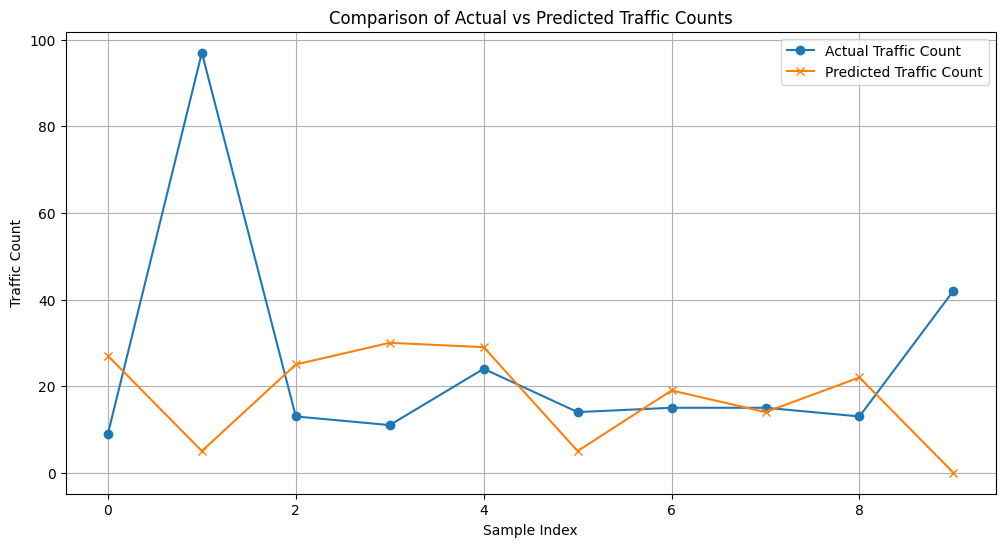

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the comparison
plt.figure(figsize=(12, 6))
plt.plot(comparison['Actual'], label='Actual Traffic Count', marker='o')
plt.plot(comparison['Predicted'], label='Predicted Traffic Count', marker='x')
plt.title('Comparison of Actual vs Predicted Traffic Counts')
plt.xlabel('Sample Index')
plt.ylabel('Traffic Count')
plt.legend()
plt.grid(True)
plt.show()